In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [2]:
df = pd.read_csv('Weekly sales for a novelty item p3738 Montgomery.csv', index_col=0)
df['x'].fillna(df['x'].mean(), inplace=True)

In [3]:
df['MA_window_3'] = df['x'].rolling(window=3).mean()
df

,x,MA_window_3
1,35,NaN
2,46,NaN
3,51,44.000000
4,46,47.666667
5,48,48.333333
...,...,...
61,79,78.333333
62,79,77.333333
63,77,78.333333
64,84,80.000000


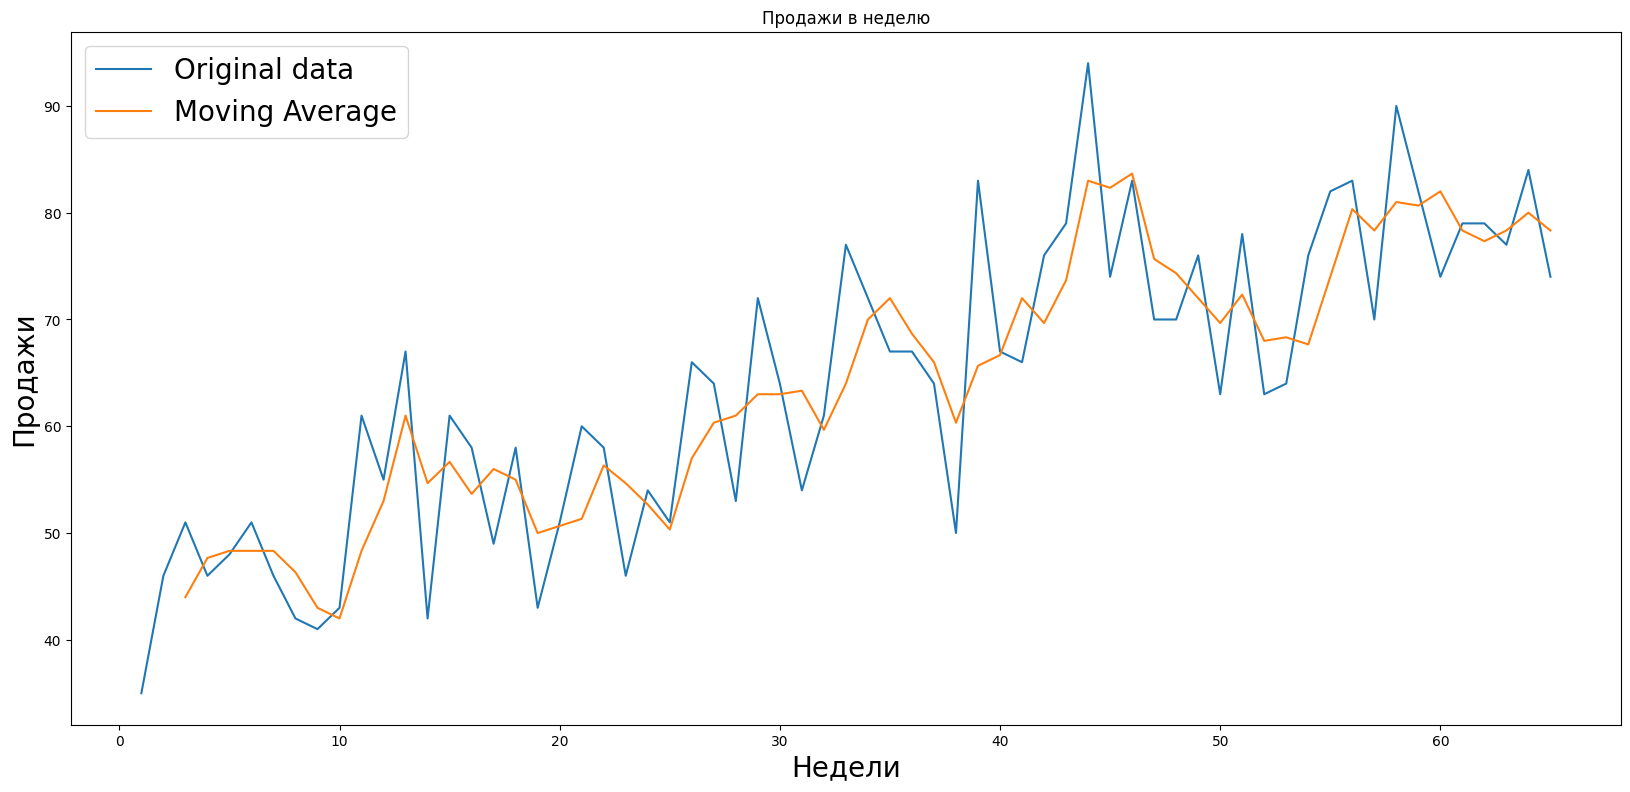

In [4]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Продажи в неделю')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Недели', fontsize="20")
plt.show()


In [5]:
'''
Отрисовка скользящего среднего по медиане для ts с 95% доверительным интервалом для стандартного отклонения.
:parameter
  :param ts: датасет
  :param window: кол-во семплов в окне - для скользящих средних
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=100,
            figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='Реальные значения', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
                 color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                     color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

<ipython-input-5-8025967e2416>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


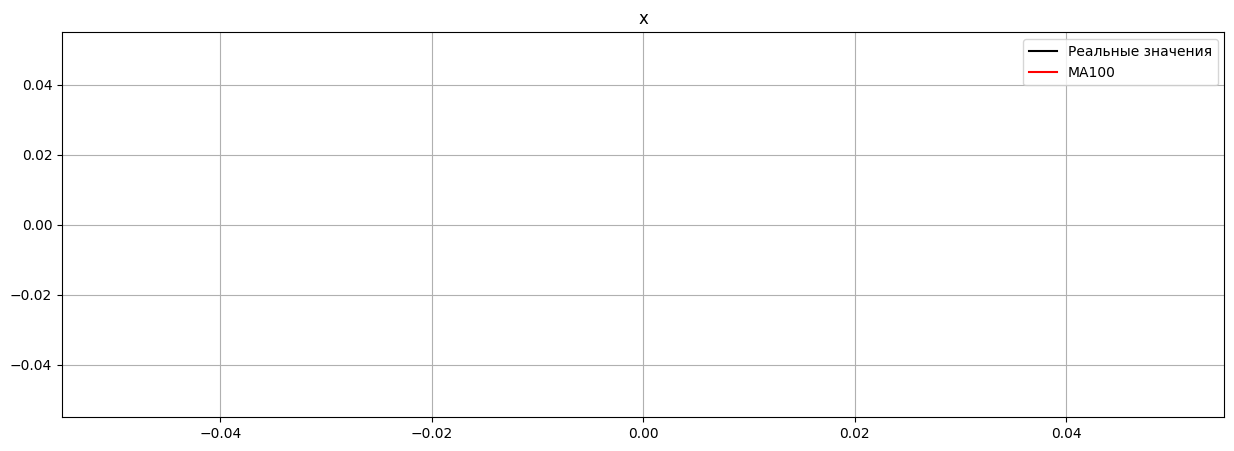

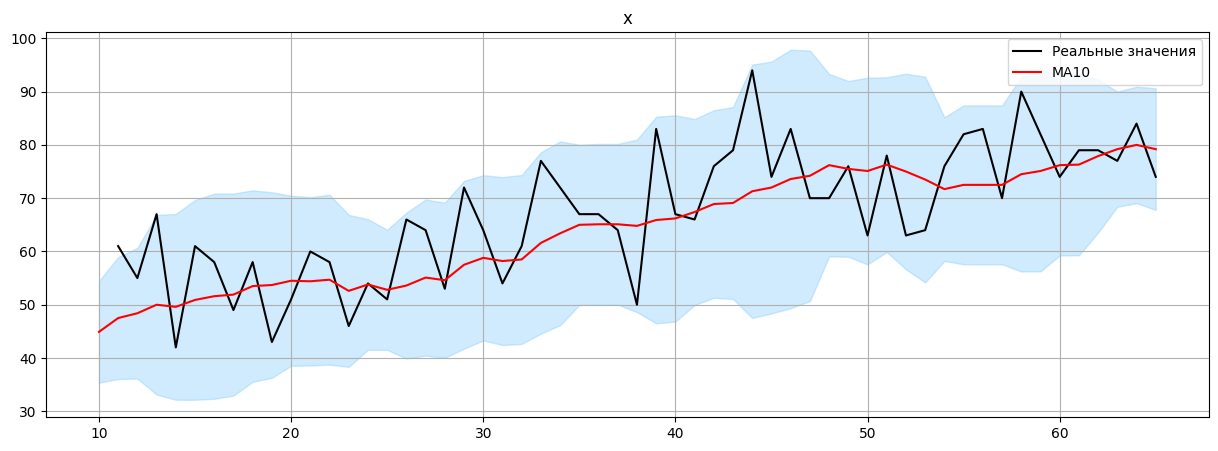

In [6]:
plot_ts(df["x"], window=100)
plot_ts(df["x"], window=10)

In [7]:
from statsmodels.tsa.arima.model import ARIMA

In [8]:
arma_model = ARIMA(df['x'], order=(5,0,3))
arma_model_fit = arma_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

In [9]:
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                   65
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -231.894
Date:                Tue, 02 Jan 2024   AIC                            483.789
Time:                        10:29:04   BIC                            505.533
Sample:                             0   HQIC                           492.368
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.3673     14.929      4.244      0.000      34.106      92.628
ar.L1         -0.9245      0.310     -2.987      0.003      -1.531      -0.318
ar.L2          0.9128      0.463      1.972      0.0

In [10]:
X = df['x'].values
size = int(len(X) / 2)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [11]:
print(len(train))
print(len(test))
print(len(arma_predictions))

32
33
33


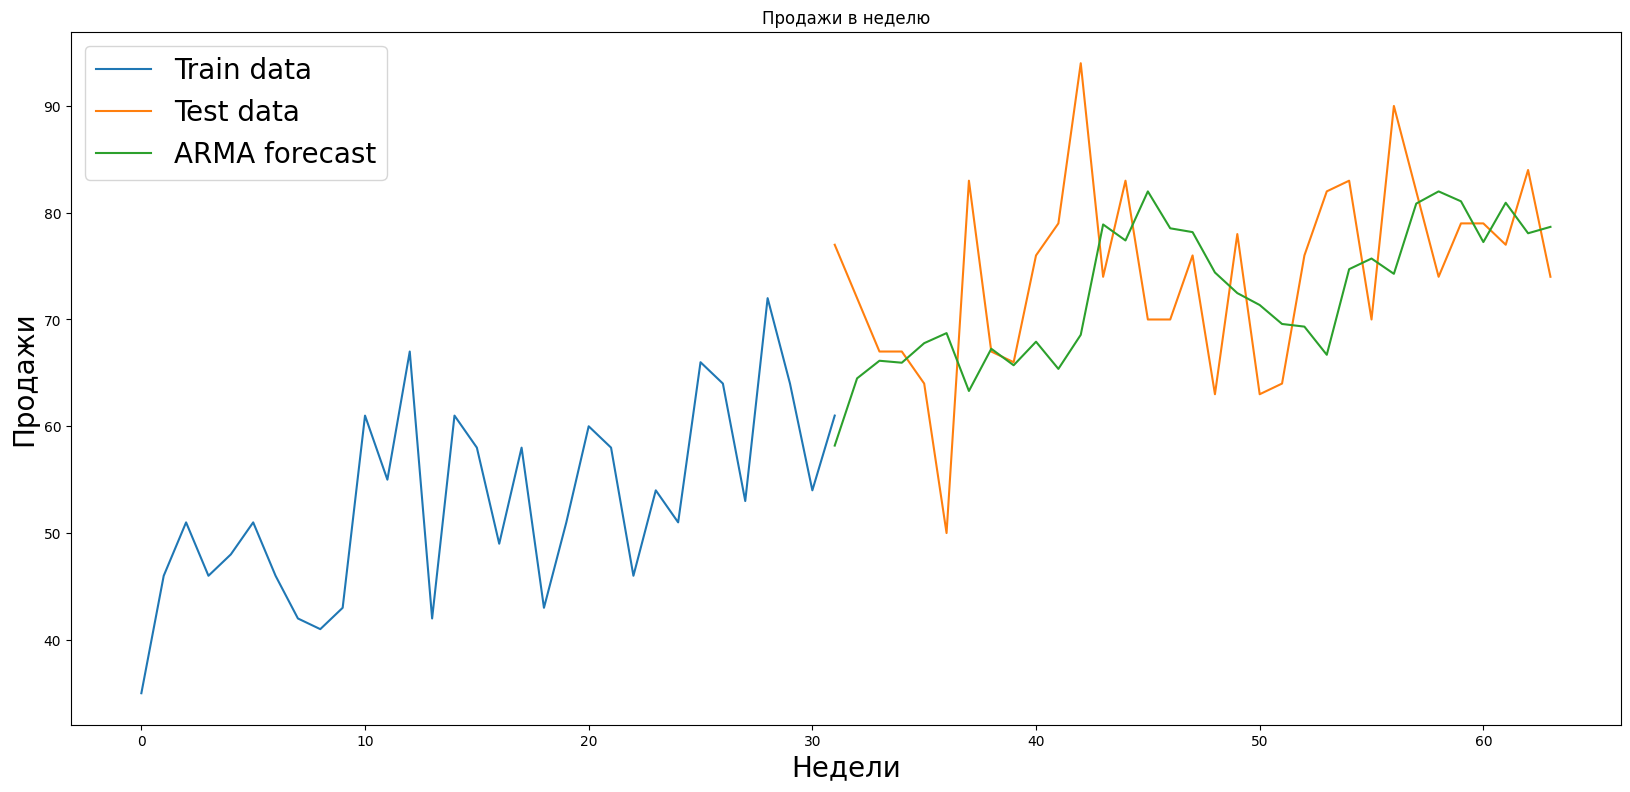

In [12]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('Продажи в неделю')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Недели', fontsize="20")
plt.show()

In [13]:
from IPython.display import clear_output
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show()

In [14]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

def calculate_smape(actual, predicted):
    return round(
        np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)))), 19)

print("RMSE:", np.sqrt(mean_squared_error(test[size - 1:size - 1 + dur], arma_predictions[size - 1:size - 1 + dur])))
print("MAPE:", mean_absolute_percentage_error(test[size - 1:size - 1 + dur], arma_predictions[size - 1:size - 1 + dur]))
print("SMAPE:", calculate_smape(test[size - 1:size - 1 + dur], arma_predictions[size - 1:size - 1 + dur]))
print("MAE:", mean_absolute_error(test[size - 1:size - 1 + dur], arma_predictions[size - 1:size - 1 + dur]))

RMSE: 5.33665601310758
MAPE: 0.06685444294371908
SMAPE: 0.03358831690224912
MAE: 5.29991191768859


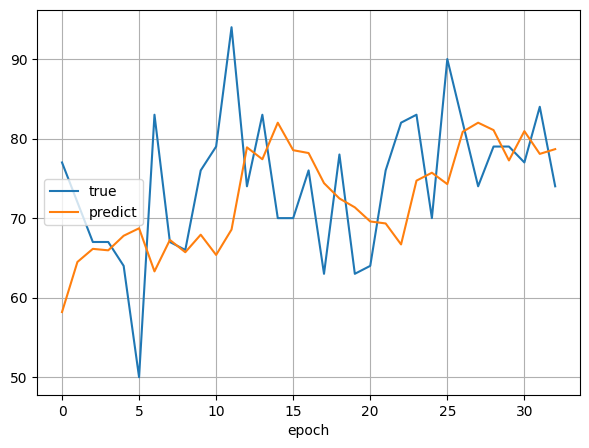

In [15]:
series = df["x"]
#series = df['1']

size = int(series.shape[0] * 0.5)
train, test = series[:size], series[size:len(series)]
history = [x for x in train.values]
predictions = []

val = {"true":[], "predict":[]}
for t in test.values:
    model = ARIMA(history, order=(5,1,0)).fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    val["predict"].append(yhat)
    val["true"].append(t)
    history.append(t)
    live_plot(val)

In [16]:
arima_model = ARIMA(df['x'], order=(10,2,10))
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

In [17]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                   65
Model:               ARIMA(10, 2, 10)   Log Likelihood                -221.660
Date:                Tue, 02 Jan 2024   AIC                            485.319
Time:                        10:29:23   BIC                            530.325
Sample:                             0   HQIC                           503.020
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5582      4.140     -0.376      0.707      -9.671       6.555
ar.L2         -1.2221      3.121     -0.392      0.695      -7.339       4.894
ar.L3         -0.6932      2.576     -0.269      0.7

<Axes: >

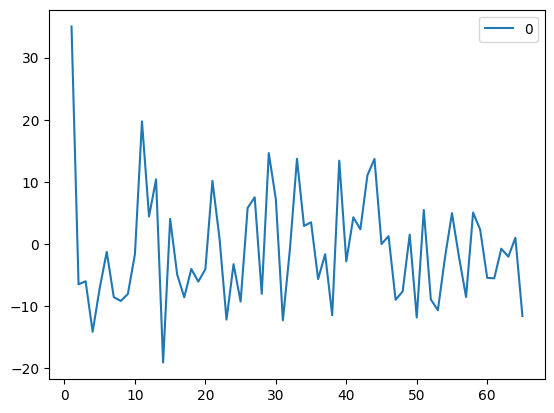

In [18]:
arima_residuals = pd.DataFrame(arima_model_fit.resid)
arima_residuals.plot()

In [19]:
# forecast предсказывает только следующее значение
output = arima_model_fit.forecast()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [20]:
X = df['x'].values
size = int(len(X) / 2)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
    arima_model = ARIMA(history, order=(10,2,5))
    arima_model_fit = arima_model.fit()
    output = arima_model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

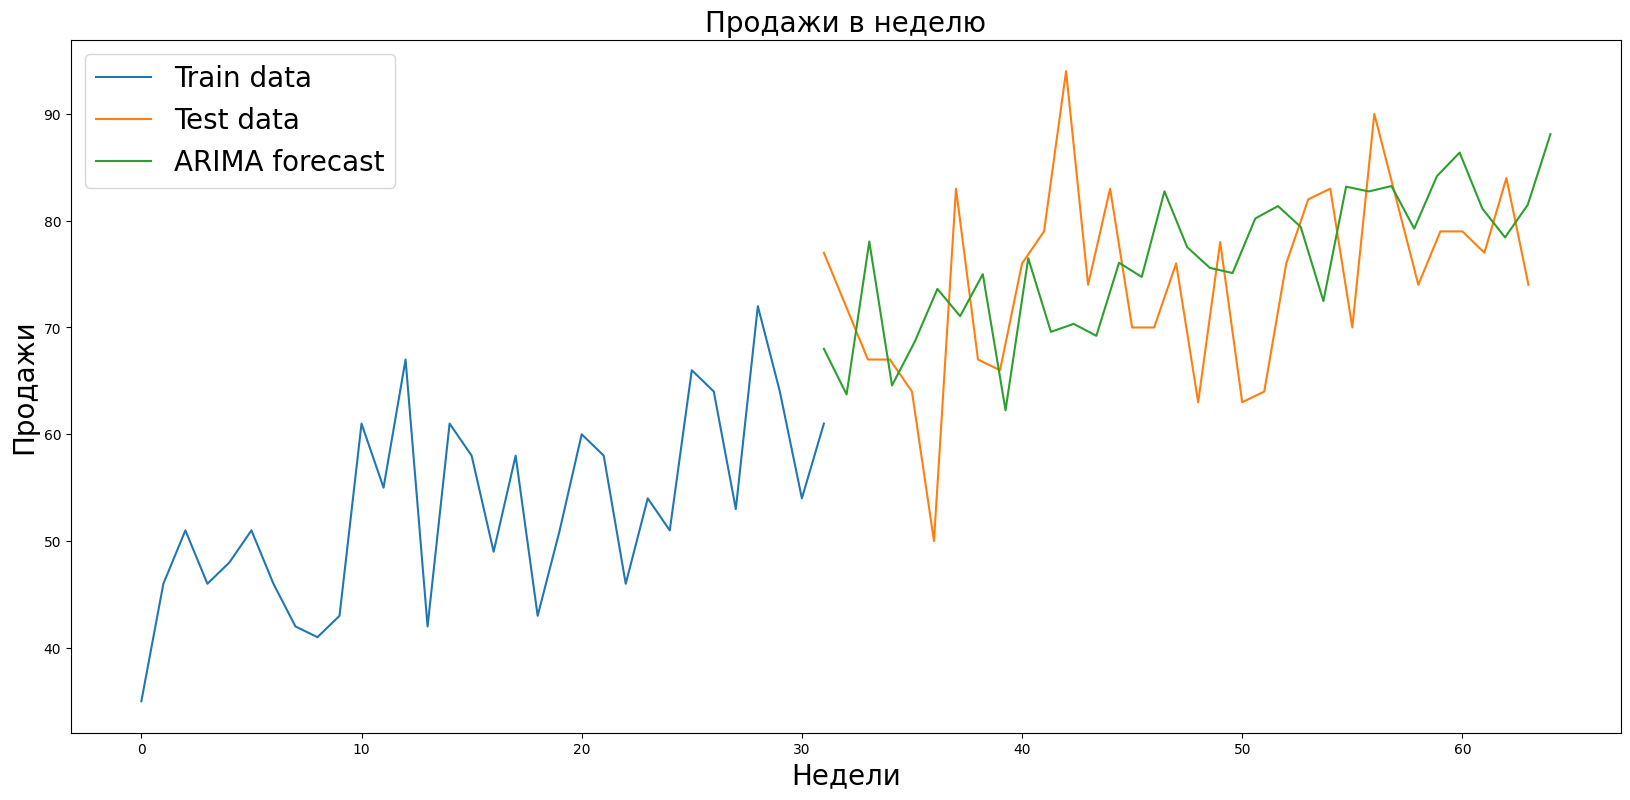

In [21]:
fig = plt.figure(figsize=(20, 9))
plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, len(X) - 1)], test, label='Test data')
plt.plot(np.linspace(size - 1, len(X) - 1, len(arima_predictions)), arima_predictions, label='ARIMA forecast')
plt.legend(fontsize=20)
plt.title('Продажи в неделю', fontsize="20")
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Недели', fontsize="20")
plt.show()


In [22]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np

def calculate_smape(actual, predicted):
    return round(
        np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)))), 19)

print("RMSE:", np.sqrt(mean_squared_error(test[:len(arima_predictions)], arima_predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:len(arima_predictions)], arima_predictions))
print("SMAPE:", calculate_smape(test[:len(arima_predictions)], arima_predictions))
print("MAE:", mean_absolute_error(test[:len(arima_predictions)], arima_predictions))



RMSE: 10.204624077510285
MAPE: 0.11593680179642496
SMAPE: 0.055388718273285745
MAE: 8.187243117377735


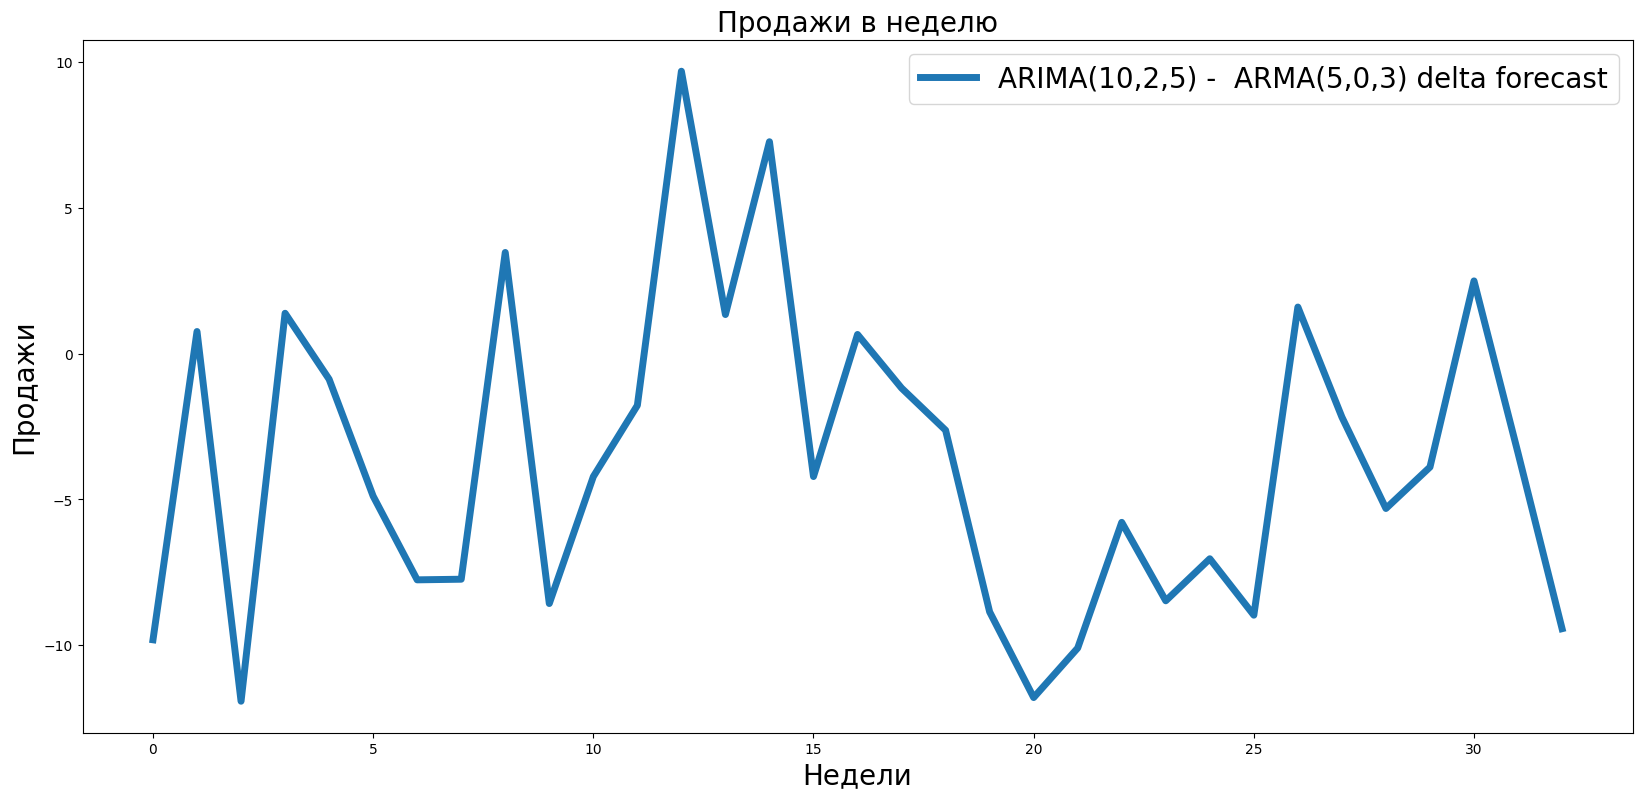

In [23]:
fig = plt.figure(figsize=(20, 9))

delta = []

for i in range(len(arima_predictions)):
    delta.append(arma_predictions[i] - arima_predictions[i])

plt.plot(delta, label='ARIMA(10,2,5) -  ARMA(5,0,3) delta forecast', linewidth=5)
plt.legend(fontsize="20")
plt.title('Продажи в неделю', fontsize="20")
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Недели', fontsize="20")
plt.show()

<ipython-input-24-c4ae46045301>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["x"][50:400] = np.nan


<Axes: >

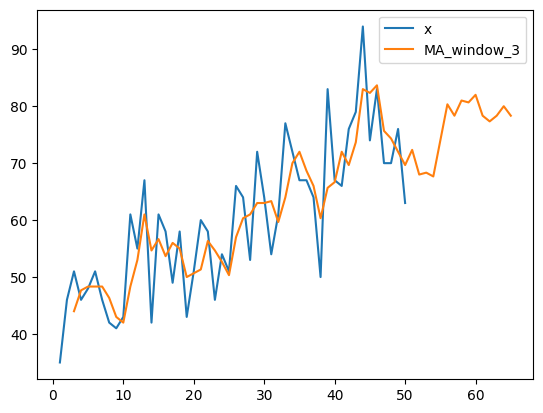

In [24]:
o_df = df.copy()

o_df["x"][50:400] = np.nan

o_df.plot()

<Axes: title={'center': 'среднее из предыдущего и последующего'}>

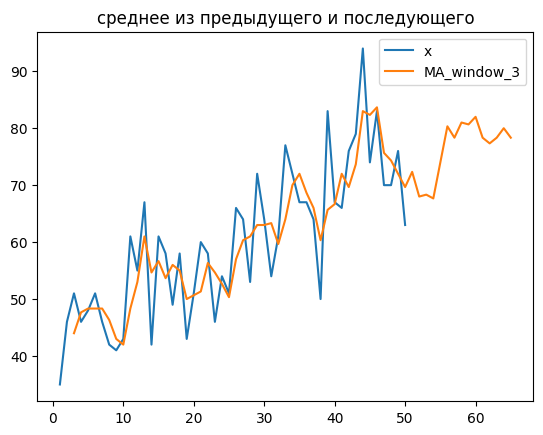

In [26]:


new_value = (o_df["x"][64] + o_df["x"][49])/2

o_df["x"][50:63] = new_value

o_df.plot(title="среднее из предыдущего и последующего")



<Axes: title={'center': 'Последующее значение'}>

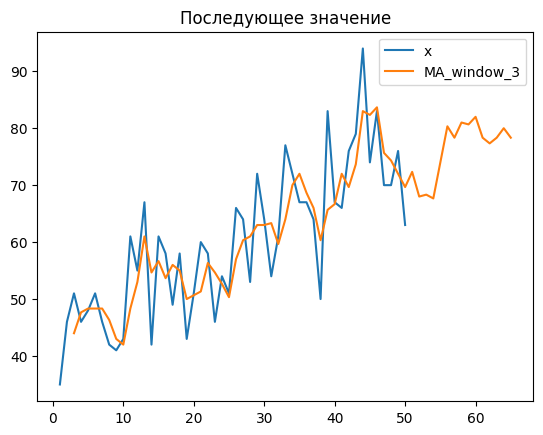

In [27]:
new_value = o_df["x"][64]

o_df["x"][50:63] = new_value

o_df.plot(title='Последующее значение')

<Axes: title={'center': 'Предыдущее значение'}>

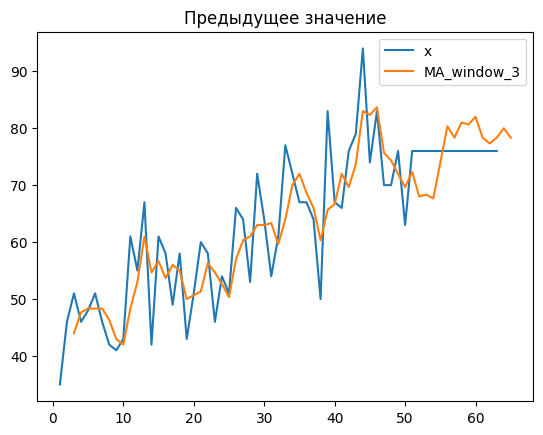

In [28]:
new_value = o_df["x"][49]

o_df["x"][50:63] = new_value

o_df.plot(title='Предыдущее значение')

<Axes: title={'center': 'медиана'}>

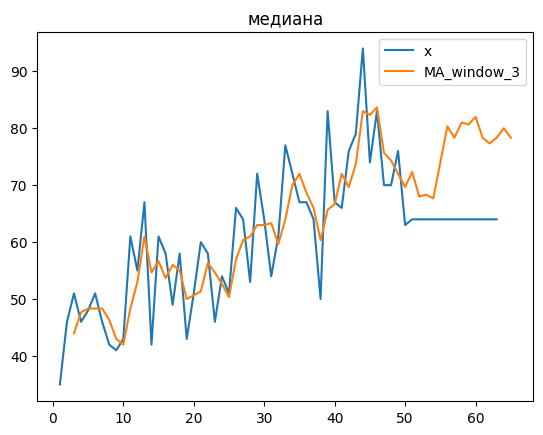

In [29]:


new_value = o_df["x"].median()

o_df["x"][50:63] = new_value

o_df.plot(title='медиана')



<Axes: title={'center': 'среднее'}>

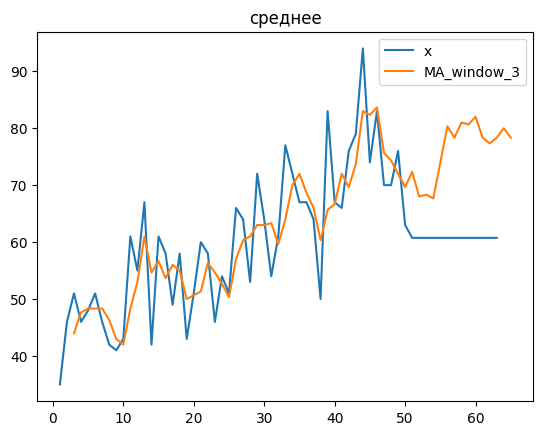

In [30]:
new_value = o_df["x"].mean()

o_df["x"][50:63] = new_value

o_df.plot(title='среднее')

<Axes: title={'center': 'zero'}>

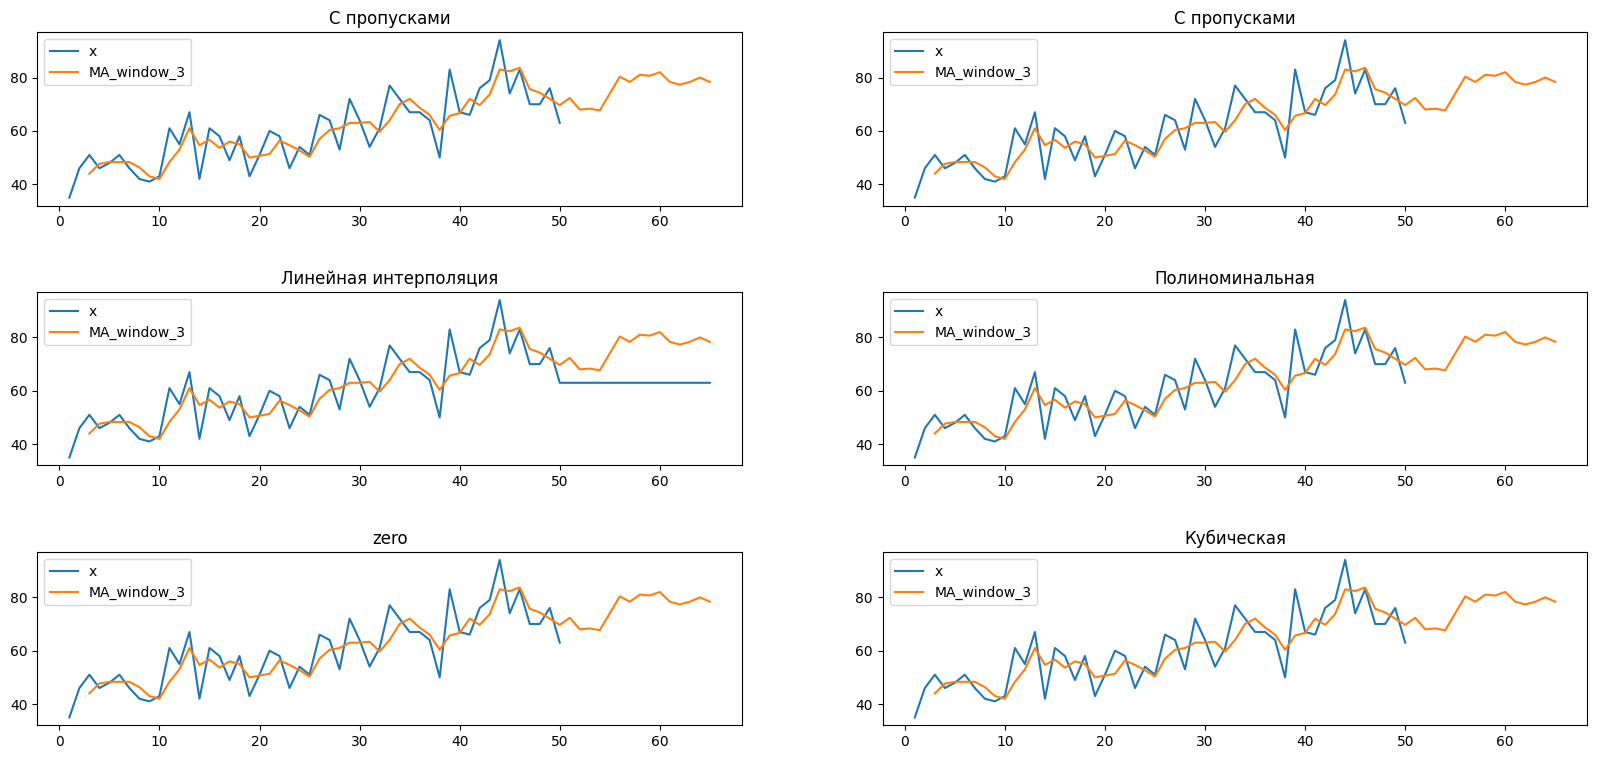

In [31]:
o_df["x"][50:63] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=5)

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))

o_df.plot(title="С пропусками", ax = original_ax)
o_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))
lin_df.plot(title="Линейная интерполяция", ax = lin_ax)
cub_df.plot(title="Кубическая", ax = cub_ax)
pol_df.plot(title="Полиноминальная", ax = pol_ax)
zero_df.plot(title="zero", ax=zero_ax)

In [32]:
import seaborn as sns

<Axes: >

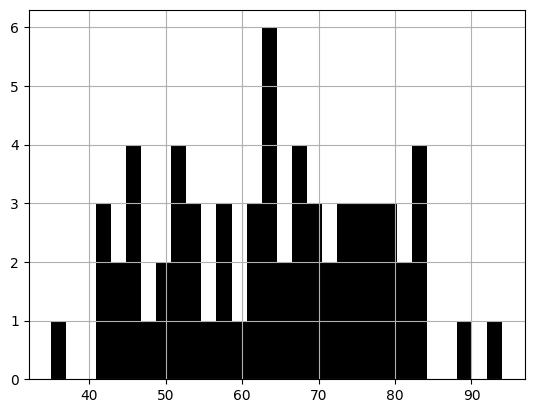

In [33]:
df["x"].hist(bins=30, color="black")

In [34]:
from sklearn import preprocessing, svm

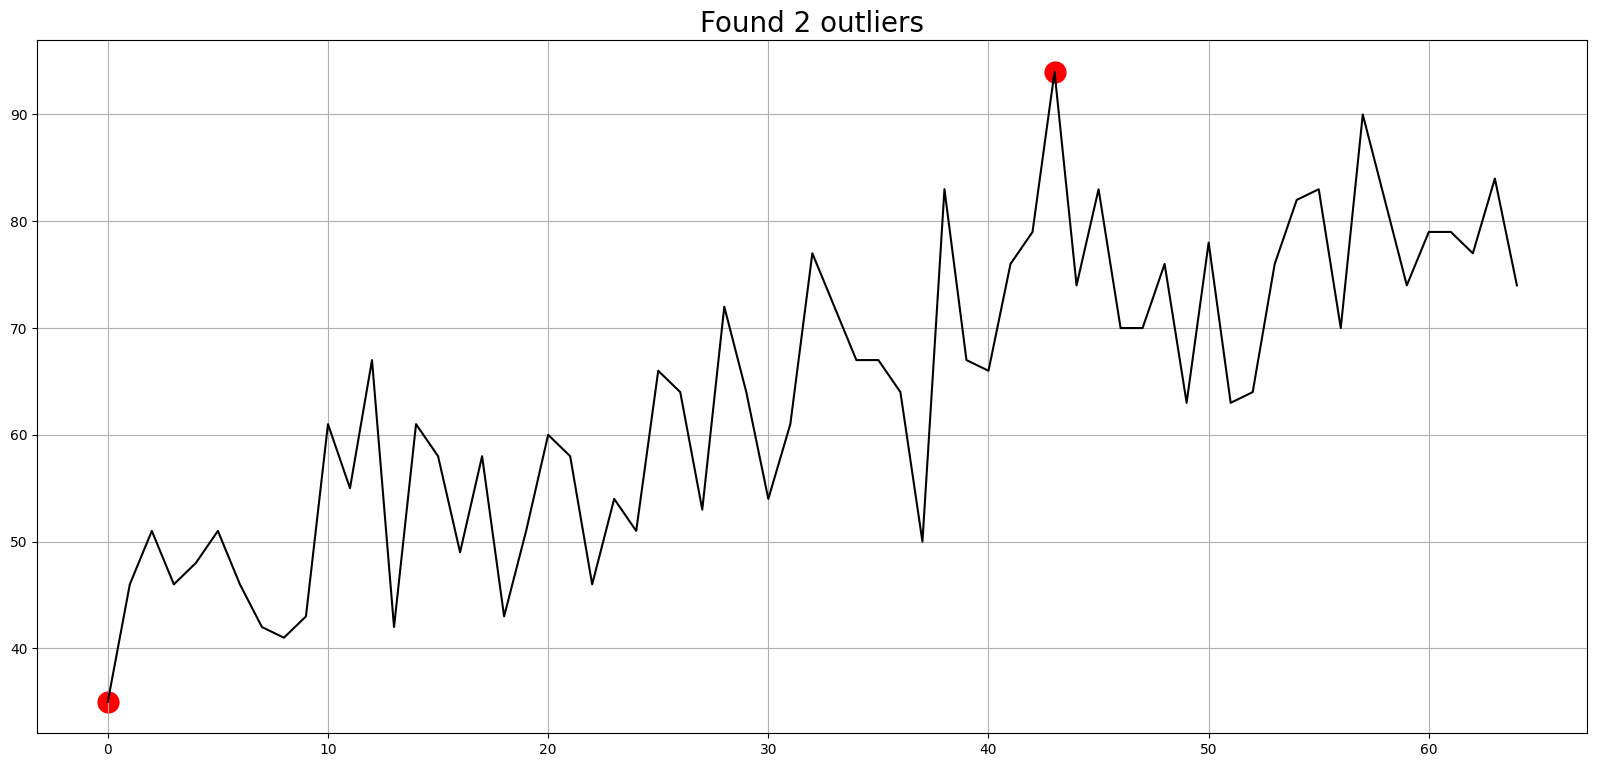

In [35]:
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = df["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)
## dtf output
dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                                            x: 1 if x==-1 else 0)
## plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

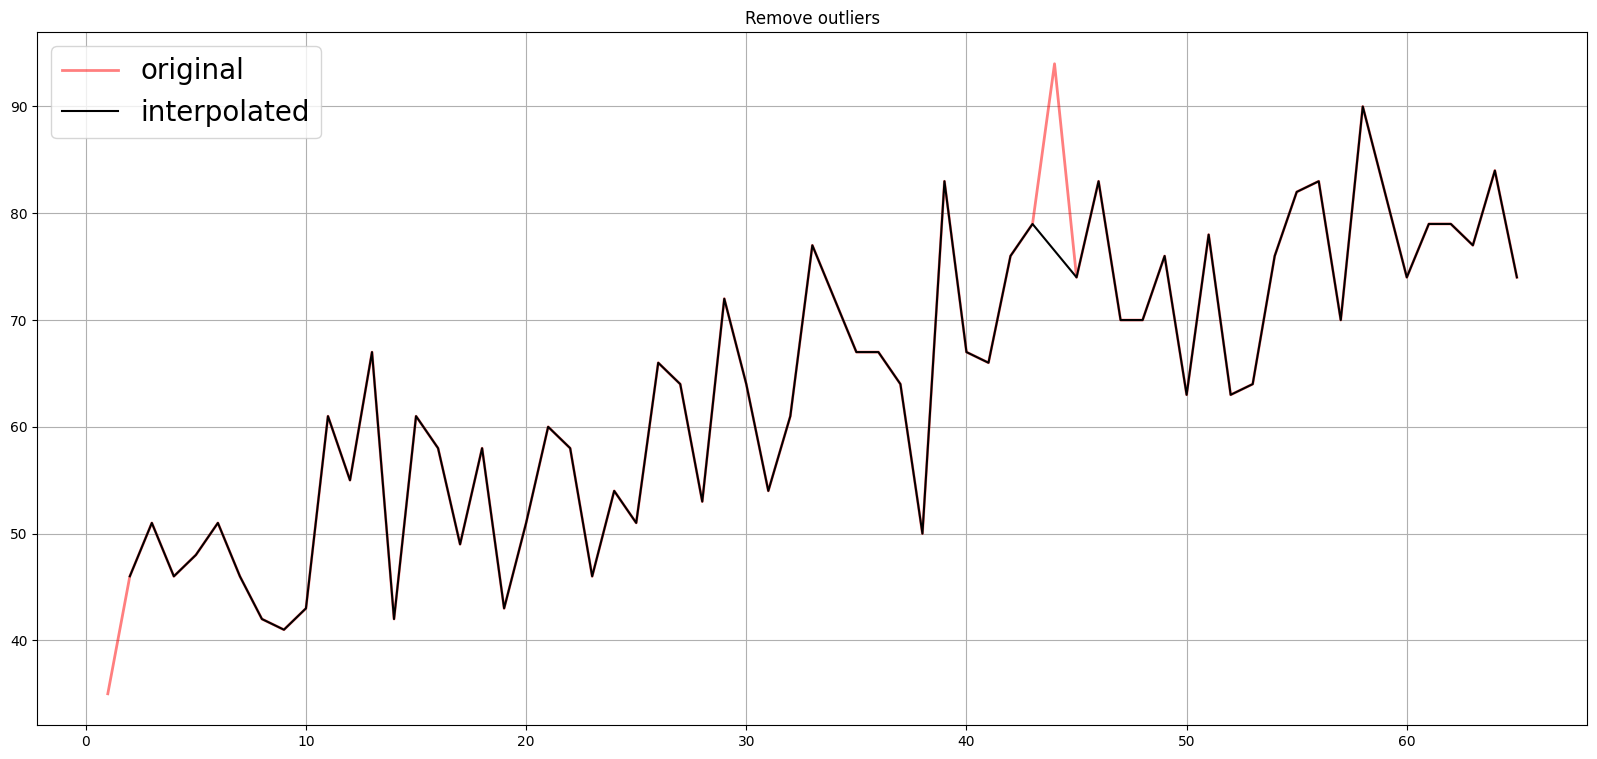

In [36]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()